In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize, stats
from astropy.table import Table

import dynesty as dy
from dynesty import plotting as dyplot
import corner

from collections import OrderedDict
import time


Bad key "text.kerning_factor" on line 4 in
/Users/alexji/anaconda/envs/newpy36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


# Crater 2

This is data taken from AAT/AAO as part of the S5 collaboration (Ji et al. in prep).
We targeted a diffuse dwarf galaxy Crater 2 and want to measure its velocity and metallicity dispersion.
We obtained multifiber spectroscopy of ~300 stars and used a pipeline to measure the radial velocities and metallicities, obtaining ~150 stars with good measurements.
Within the field of view, targets are selected based off of their color-magnitude diagrams and proper motions. This can still leave substantial contamination from disk or halo stars that can be separated using the stellar velocities and metallicities.

We will fit a Gaussian mixture model to this data using `emcee`.

In [2]:
tab = Table.read("DR2.2beta_extra_Crater2.fits")

In [3]:
quality_cuts = (tab["best_sn_1700d"] > 4) & (tab["vel_calib_std"] < 10) & (np.abs(tab["vel_calib"]) < 500)
tab = tab[quality_cuts]

## Remove bad [Fe/H] without removing their velocity
tab["feh_calib_std"][tab["feh_calib_std"] > 0.5] = 99.
## Remove binary candidates without removing their feh
tab["vel_calib_std"][tab["bincand"]] = 999.

In [4]:
len(tab)

149

In [5]:
tab.colnames

['absdev_1700d_0',
 'absdev_580v_0',
 'alpha1',
 'alpha16',
 'alpha50',
 'alpha84',
 'alpha99',
 'alpha_kurt',
 'alpha_mean',
 'alpha_skew',
 'alpha_std',
 'chisq_1700d_0',
 'chisq_580v_0',
 'chisq_cont_1700d_0',
 'chisq_cont_580v_0',
 'comment',
 'dec',
 'feh1',
 'feh16',
 'feh50',
 'feh84',
 'feh99',
 'feh_kurt',
 'feh_mean',
 'feh_skew',
 'feh_std',
 'field',
 'fig_name',
 'fileinfo',
 'logg1',
 'logg16',
 'logg50',
 'logg84',
 'logg99',
 'logg_kurt',
 'logg_mean',
 'logg_skew',
 'logg_std',
 'name',
 'ra',
 'redchisq_1700d_0',
 'redchisq_580v_0',
 'sn_1700d_0',
 'sn_580v_0',
 'teff1',
 'teff16',
 'teff50',
 'teff84',
 'teff99',
 'teff_kurt',
 'teff_mean',
 'teff_skew',
 'teff_std',
 'utend',
 'utmjd',
 'utstart',
 'vel1',
 'vel16',
 'vel50',
 'vel84',
 'vel99',
 'vel_blue1',
 'vel_blue16',
 'vel_blue50',
 'vel_blue84',
 'vel_blue99',
 'vel_blue_kurt',
 'vel_blue_mean',
 'vel_blue_skew',
 'vel_blue_std',
 'vel_kurt',
 'vel_mean',
 'vel_skew',
 'vel_std',
 'absdev_580v_1',
 'chisq_58

[(-100, 400),
 Text(0, 0.5, 'vhel (km/s)'),
 (-4, 1),
 Text(0.5, 0, '[Fe/H] (dex)')]

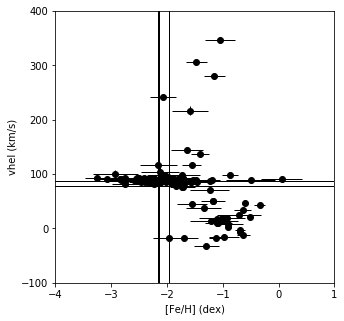

In [6]:
## Pull out the relevant data columns
rv = tab["vel_calib"] # heliocentric radial velocity
rverr = tab["vel_calib_std"]

feh = tab["feh50"]
feherr = tab["feh_calib_std"]

fig, ax = plt.subplots(figsize=(5,5))
ax.errorbar(feh, rv, xerr=feherr, yerr=rverr, fmt='o', elinewidth=1, color='k')
ax.set(xlabel="[Fe/H] (dex)", ylabel="vhel (km/s)", xlim=(-4,1), ylim=(-100,400))


Text(0.5, 0, '[Fe/H]')

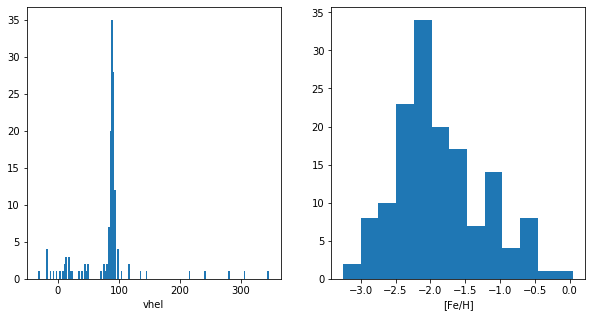

In [7]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].hist(rv, bins='auto');
axes[0].set_xlabel("vhel")
axes[1].hist(feh, bins='auto');
axes[1].set_xlabel("[Fe/H]")

By eye, there are 2-3 components. We will model these as a mixture of 3 gaussians. The parameters will be:

* pgal = fraction of stars in the galaxy
* pbg1 = fraction of stars in the 1st background component
* vhel = mean velocity of the galaxy in km/s
* lsigv = log10 the velocity dispersion of the galaxy in km/s
* feh = mean metallicity of the galaxy in dex
* lsigfeh = log10 the metallicity dispersion of the galaxy in dex
* vbg1, lsigvbg1, fehbg1, lsigfeh1 = same parameters for 1st background component
* vbg2, lsigvbg2, fehbg2, lsigfeh2 = same parameters for 2nd background component

In total there are 14 parameters.

# Likelihood function and Prior Transform (start here if you did the emcee example)

The likelihood is exactly the same as what you put into emcee, but get rid of any prior that you put in.

Instead, define a "prior transform" function. The input to this function is a vector of uniform random variables (from 0 to 1).
Your job is to turn that into the actual parameters used in your function.
https://en.wikipedia.org/wiki/Inverse_transform_sampling

What dynesty does is draw samples from within the unit hypercube, removing a point with the smallest likelihood and adding a new point in a region of strictly higher likelihood (the hard part of the algorithm is how to efficiently add new points; but if you're willing to be inefficient, you can just wait longer).
The removed points are your samples, and they are weighted by the likelihood.
In the process, it will go through the *entire* prior, meaning it computes the evidence (the denominator in Bayes's theorem). This is why it is very slow and maybe takes ~10x as long, depending on your prior volume.
It also goes until the sampling passes through the typical set of the posterior, which it knows how to compute and increases montonically.

In [8]:
param_labels = ["pgal","pbg1",
                "vhel","lsigv","feh","lsigfeh",
                "vbg1","lsigvbg1","fehbg1","lsigfeh1",
                "vbg2","lsigvbg2","fehbg2","lsigfeh2"]
def ptform(u):
    """ Prior transform: turn a vector of uniform random variables into a parameter vector """
    ## Here the transformations are easy because everything is just uniform
    ## You can always use the inverse CDF method to turn a 1D uniform random variable into anything
    ## The more restricted you can make your prior, the faster this will sample!
    
    # u[0] pgal: unif(0,1)
    # u[1] pbg1: unif(0,1)
    
    # vhel: unif(50,150)
    u[2] = 100*u[2] + 50
    # lsigv: unif(-1, 3)
    u[3] = 4*u[3] - 1
    # feh: unif(-3, -1)
    u[4] = 2*u[4] - 3
    # lsigfeh: unif(-2, 1)
    u[5] = 3*u[5] - 2
    
    # bg1
    # vhel: unif(50,500)
    u[6] = 450*u[6] + 50
    # lsigv: unif(-1, 3)
    u[7] = 4*u[7] - 1
    # feh: unif(-3, -1)
    u[8] = 2*u[8] - 3
    # lsigfeh: unif(-2, 1)
    u[9] = 3*u[9] - 2
    
    # bg2
    # vhel: unif(-50,50)
    u[10] = 100*u[10] - 50
    # lsigv: unif(-1, 3)
    u[11] = 4*u[11] - 1
    # feh: unif(-3, -1)
    u[12] = 2*u[12] - 3
    # lsigfeh: unif(-2, 1)
    u[13] = 3*u[13] - 2
    
    return u
def lnprob(theta, rv, rverr, feh, feherr):
    """ Likelihood ONLY """
    pgal, pbg1, \
    vhel, lsigv, feh0, lsigfeh, \
    vbg1, lsigvbg1, fehbg1, lsigfeh1, \
    vbg2, lsigvbg2, fehbg2, lsigfeh2 = theta
    
    ## NOTE: For dynesty we need to specify a separate function for the prior, the "prior transform"
    ## It has to be defined for *all* the parameters
    ## The prior is just a bunch of hard cutoffs
    #if (pgal > 1) or (pgal < 0) or (pbg1 > 1) or (pbg1 < 0) or \
    #    (lsigv > 3) or (lsigvbg1 > 3) or (lsigvbg2 > 3) or \
    #    (lsigv < -1) or (lsigvbg1 < -1) or (lsigvbg2 < -1) or \
    #    (lsigfeh > 1) or (lsigfeh1 > 1) or (lsigfeh1 > 1) or \
    #    (lsigfeh < -3) or (lsigfeh1 < -3) or (lsigfeh1 < -3) or \
    #    (vhel > 150) or (vhel < 50) or (vbg1 > 500) or (vbg1 < 50) or \
    #    (vbg2 > 50) or (vbg2 < -50):
    #    return -1e10 # outside of prior, return a tiny number
    
    ## Compute log likelihood in rv
    lgal_vhel = stats.norm.logpdf(rv, loc=vhel, scale=np.sqrt(rverr**2 + (10**lsigv)**2))
    lbg1_vhel = stats.norm.logpdf(rv, loc=vbg1, scale=np.sqrt(rverr**2 + (10**lsigvbg1)**2))
    lbg2_vhel = stats.norm.logpdf(rv, loc=vbg2, scale=np.sqrt(rverr**2 + (10**lsigvbg2)**2))
    
    ## Compute log likelihood in feh
    lgal_feh = stats.norm.logpdf(feh, loc=feh0,    scale=np.sqrt(feherr**2 + (10**lsigfeh)**2))
    lbg1_feh = stats.norm.logpdf(feh, loc=fehbg1, scale=np.sqrt(feherr**2 + (10**lsigfeh1)**2))
    lbg2_feh = stats.norm.logpdf(feh, loc=fehbg2, scale=np.sqrt(feherr**2 + (10**lsigfeh2)**2))
    
    ## Note: If for some reason you have covariances, e.g. for Gaia proper motions, 
    ## you can use stats.multivariate_normal.logpdf
    
    ## Combine the components
    lgal = np.log(pgal) + lgal_vhel + lgal_feh
    lbg1 = np.log(pbg1) + lbg1_vhel + lbg1_feh
    lbg2 = np.log(1-pbg1) + lbg2_vhel + lbg2_feh
    ## np.logaddexp takes the exp, adds them, and re-lns them in a numerically stable way
    lbgtot = np.logaddexp(lbg1, lbg2)
    ltot = np.logaddexp(lgal, np.log(1-pgal) + lbgtot)
    
    return np.sum(ltot)

def get_paramdict(theta):
    return OrderedDict(zip(param_labels, theta))
def project_model(theta, rvmin=-200, rvmax=500, fehmin=-4, fehmax=1):
    """ Turn parameters into rv and feh distributions """
    params = get_paramdict(theta)
    rvarr = np.linspace(rvmin, rvmax, 1000)
    feharr = np.linspace(fehmin, fehmax, 1000)
    
    prv0 = params["pgal"]*stats.norm.pdf(rvarr, loc=params["vhel"], scale=10**params["lsigv"])
    prv1 = (1-params["pgal"])*params["pbg1"]*stats.norm.pdf(rvarr, loc=params["vbg1"], scale=10**params["lsigvbg1"])
    prv2 = (1-params["pgal"])*(1-params["pbg1"])*stats.norm.pdf(rvarr, loc=params["vbg2"], scale=10**params["lsigvbg2"])
    
    pfe0 = params["pgal"]*stats.norm.pdf(feharr, loc=params["feh"], scale=10**params["lsigfeh"])
    pfe1 = (1-params["pgal"])*params["pbg1"]*stats.norm.pdf(feharr, loc=params["fehbg1"], scale=10**params["lsigfeh1"])
    pfe2 = (1-params["pgal"])*(1-params["pbg1"])*stats.norm.pdf(feharr, loc=params["fehbg2"], scale=10**params["lsigfeh2"])
    return rvarr, prv0, prv1, prv2, feharr, pfe0, pfe1, pfe2

def plot_1d_distrs(theta):
    ## I'm being lazy and just using the global variables rv, rverr, feh, feherr.
    ## This makes life hard if you need to debug, but oops
    colors = list(plt.rcParams["axes.prop_cycle"].by_key()["color"])
    model_output = project_model(theta)

    fig, axes = plt.subplots(1,2,figsize=(10,5))
    ax = axes[0]
    ax.hist(rv, density=True, color='grey', bins='auto')
    xp, p0, p1, p2 = model_output[0:4]
    ax.plot(xp, p0 + p1 + p2, 'k-', label="Total", lw=3)
    ax.plot(xp, p2, ':', color=colors[2], label="bg2", lw=3)
    ax.plot(xp, p1, ':', color=colors[1], label="bg1", lw=3)
    ax.plot(xp, p0, ':', color=colors[0], label="gal", lw=3)
    ax.legend(fontsize='small')

    ax = axes[1]
    ax.hist(feh, density=True, color='grey', bins='auto')
    xp, p0, p1, p2 = model_output[4:8]
    ax.plot(xp, p0 + p1 + p2, 'k-', lw=3)
    ax.plot(xp, p2, ':', color=colors[2], lw=3)
    ax.plot(xp, p1, ':', color=colors[1], lw=3)
    ax.plot(xp, p0, ':', color=colors[0], lw=3)
    return fig
def plot_2d_distr(theta):
    fig, ax = plt.subplots(figsize=(5,5))
    ax.plot(feh, rv, 'k.')
    ax.set(xlabel="[Fe/H] (dex)", ylabel="vhel (km/s)", xlim=(-4,1), ylim=(-100,400))
    
    params = get_paramdict(theta)
    colors = list(plt.rcParams["axes.prop_cycle"].by_key()["color"])
    ax.errorbar(params["feh"], params["vhel"],
               xerr=2*10**params["lsigfeh"], yerr=2*10**params["lsigv"],
               color=colors[0], marker='o', elinewidth=1, capsize=3, zorder=9999)
    ax.errorbar(params["fehbg1"], params["vbg1"],
               xerr=2*10**params["lsigfeh1"], yerr=2*10**params["lsigvbg1"],
               color=colors[1], marker='x', elinewidth=1, capsize=3, zorder=9999)
    ax.errorbar(params["fehbg2"], params["vbg2"],
               xerr=2*10**params["lsigfeh2"], yerr=2*10**params["lsigvbg2"],
               color=colors[2], marker='.', elinewidth=1, capsize=3, zorder=9999)

    ax.grid()

# Optimize parameters: not needed

Unlike MCMC, dynamic nested sampling does a complete parameter space search. (This is why it is good for multiple modes.)


# Run the sampler

This next sampling step takes about 12 minutes on Alex's laptop. A good time to take a break!

It will go until `stop` is < 1.

In [11]:
%%time
from schwimmbad import MultiPool

ndim = len(param_labels)
nproc = 8
with MultiPool(nproc) as pool:
    dsampler = dy.DynamicNestedSampler(lnprob, ptform, ndim=ndim, pool=pool,
                                      logl_args=(rv, rverr, feh, feherr))
    dsampler.run_nested()


7388it [00:58, 70.51it/s, batch: 0 | bound: 88 | nc: 25 | ncall: 160412 | eff(%):  4.591 | loglstar:   -inf < -755.195 <    inf | logz: -771.809 +/-  0.249 | dlogz: 37.546 >  0.010]  /Users/alexji/anaconda/envs/newpy36/lib/python3.6/site-packages/dynesty/sampling.py:238: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
8689it [01:14, 101.99it/s, batch: 0 | bound: 109 | nc: 25 | ncall: 196547 | eff(%):  4.410 | loglstar:   -inf < -737.963 <    inf | logz: -756.851 +/-  0.266 | dlogz: 26.992 >  0.010]/Users/alexji/anaconda/envs/newpy36/lib/python3.6/site-packages/dynesty/sampling.py:216: UserWarning: Random number generation appears to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random number generation appears to be "
8819it [01:18, 38.88it/s, batch: 0 | bound: 113 | nc: 25 | ncall: 202424 | eff(%):  4.346 | loglstar:   -inf < -736.58

CPU times: user 1min 50s, sys: 1min 52s, total: 3min 42s
Wall time: 11min 4s


In [12]:
## Save the results this way:
import pickle
dresults = dsampler.results
with open("dynesty_output.pkl", "wb") as fp:
    pickle.dump(dresults, fp)

## Plotting results and computing 

dynesty returns samples *with weights*. This means that you cannot just directly take corner plots of the chain, you have to weight the points. Fortunately it includes quick plotting functions, as well as a function to quickly convert weighted to unweighted samples.

In [14]:
## Examine the output
dresults.keys()

dict_keys(['niter', 'ncall', 'eff', 'samples', 'samples_id', 'samples_batch', 'samples_it', 'samples_u', 'samples_n', 'logwt', 'logl', 'logvol', 'logz', 'logzerr', 'information', 'batch_nlive', 'batch_bounds', 'bound', 'bound_iter', 'samples_bound', 'scale'])

In [19]:
## The likelihood of the samples is strictly increasing!
print(dresults["logl"], np.all(np.sort(dresults["logl"])==dresults["logl"]))
## There's also the evidence if you want that
print(dresults["logz"], np.all(np.sort(dresults["logz"])==dresults["logz"]))

[-63061.78327663 -58648.46544959 -55319.66547778 ...   -701.47014412
   -701.30738396   -701.27558044] True
[-63068.69302991 -58655.37720087 -55326.57922706 ...   -735.14966714
   -735.14964841   -735.14962783] True


This plot shows diagnostics about how well the run went. I don't really know what to look for because it always looks the same to me, but you can look online at the documentation.

(<Figure size 1152x1152 with 4 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x125816f60>,
       dtype=object))

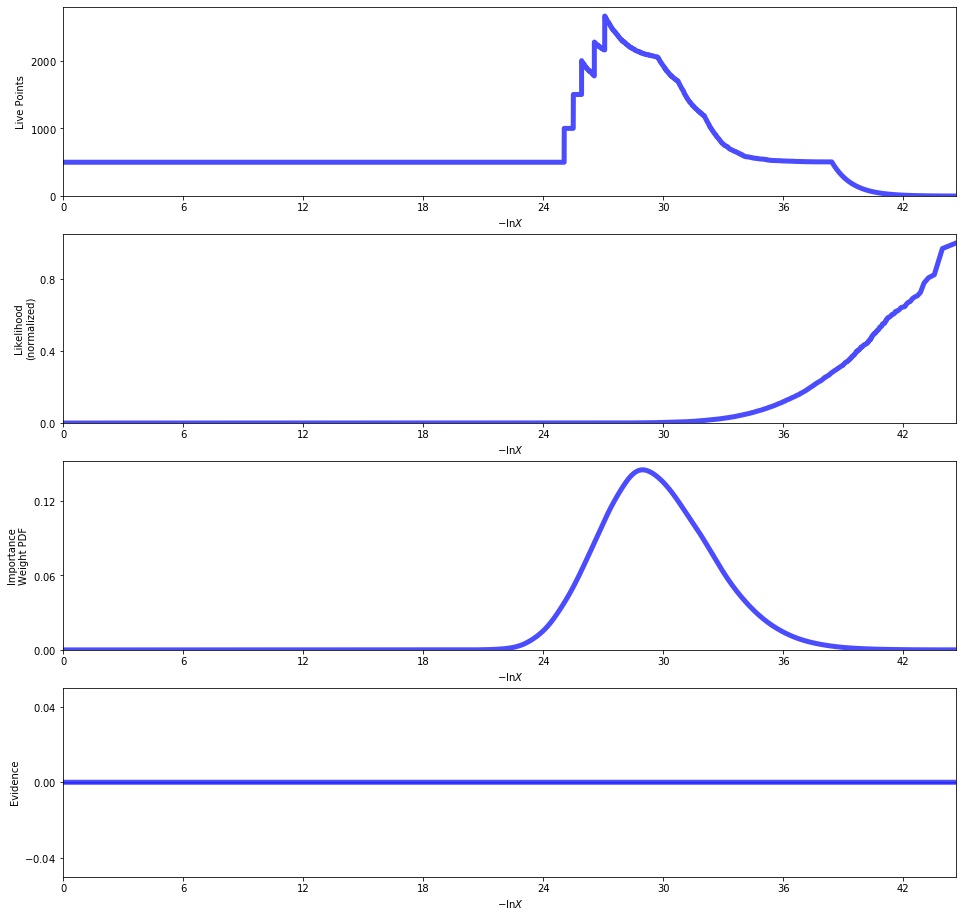

In [20]:
dyplot.runplot(dresults)

This plot shows the values for each variable as the sampler progresses (from low to high -lnX) and the 1D marginalized distributions.

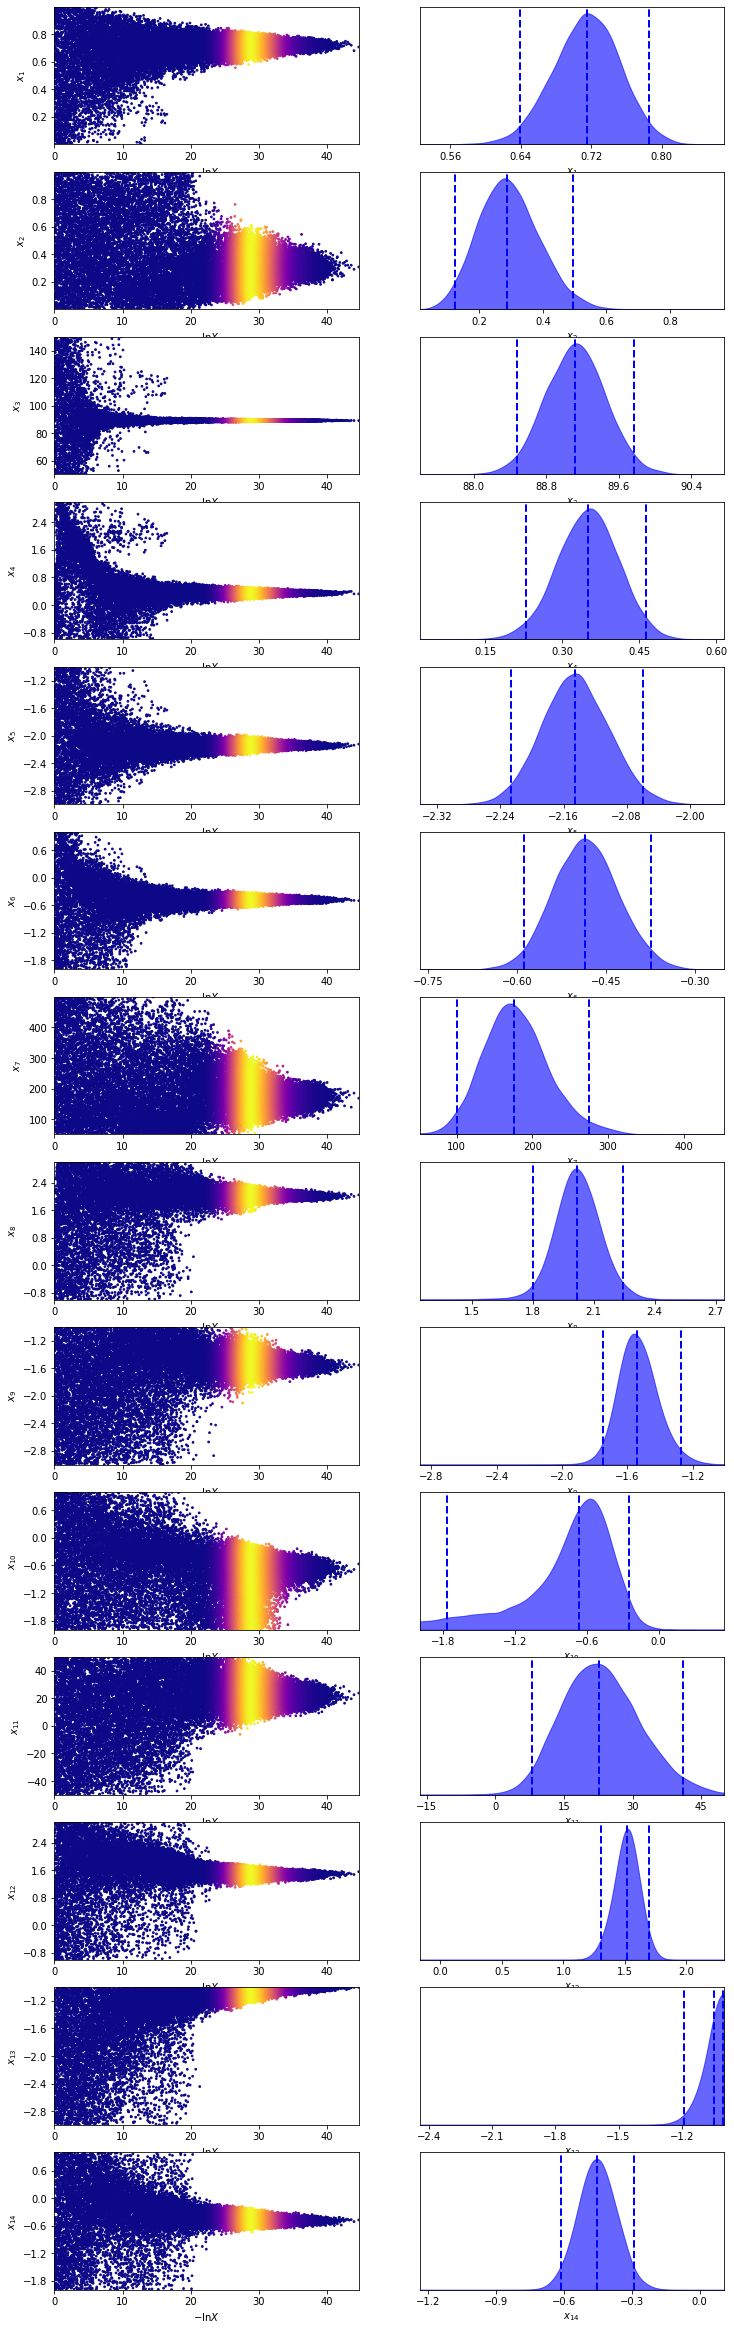

In [22]:
dyplot.traceplot(dresults);

This is a corner plot, including the weights

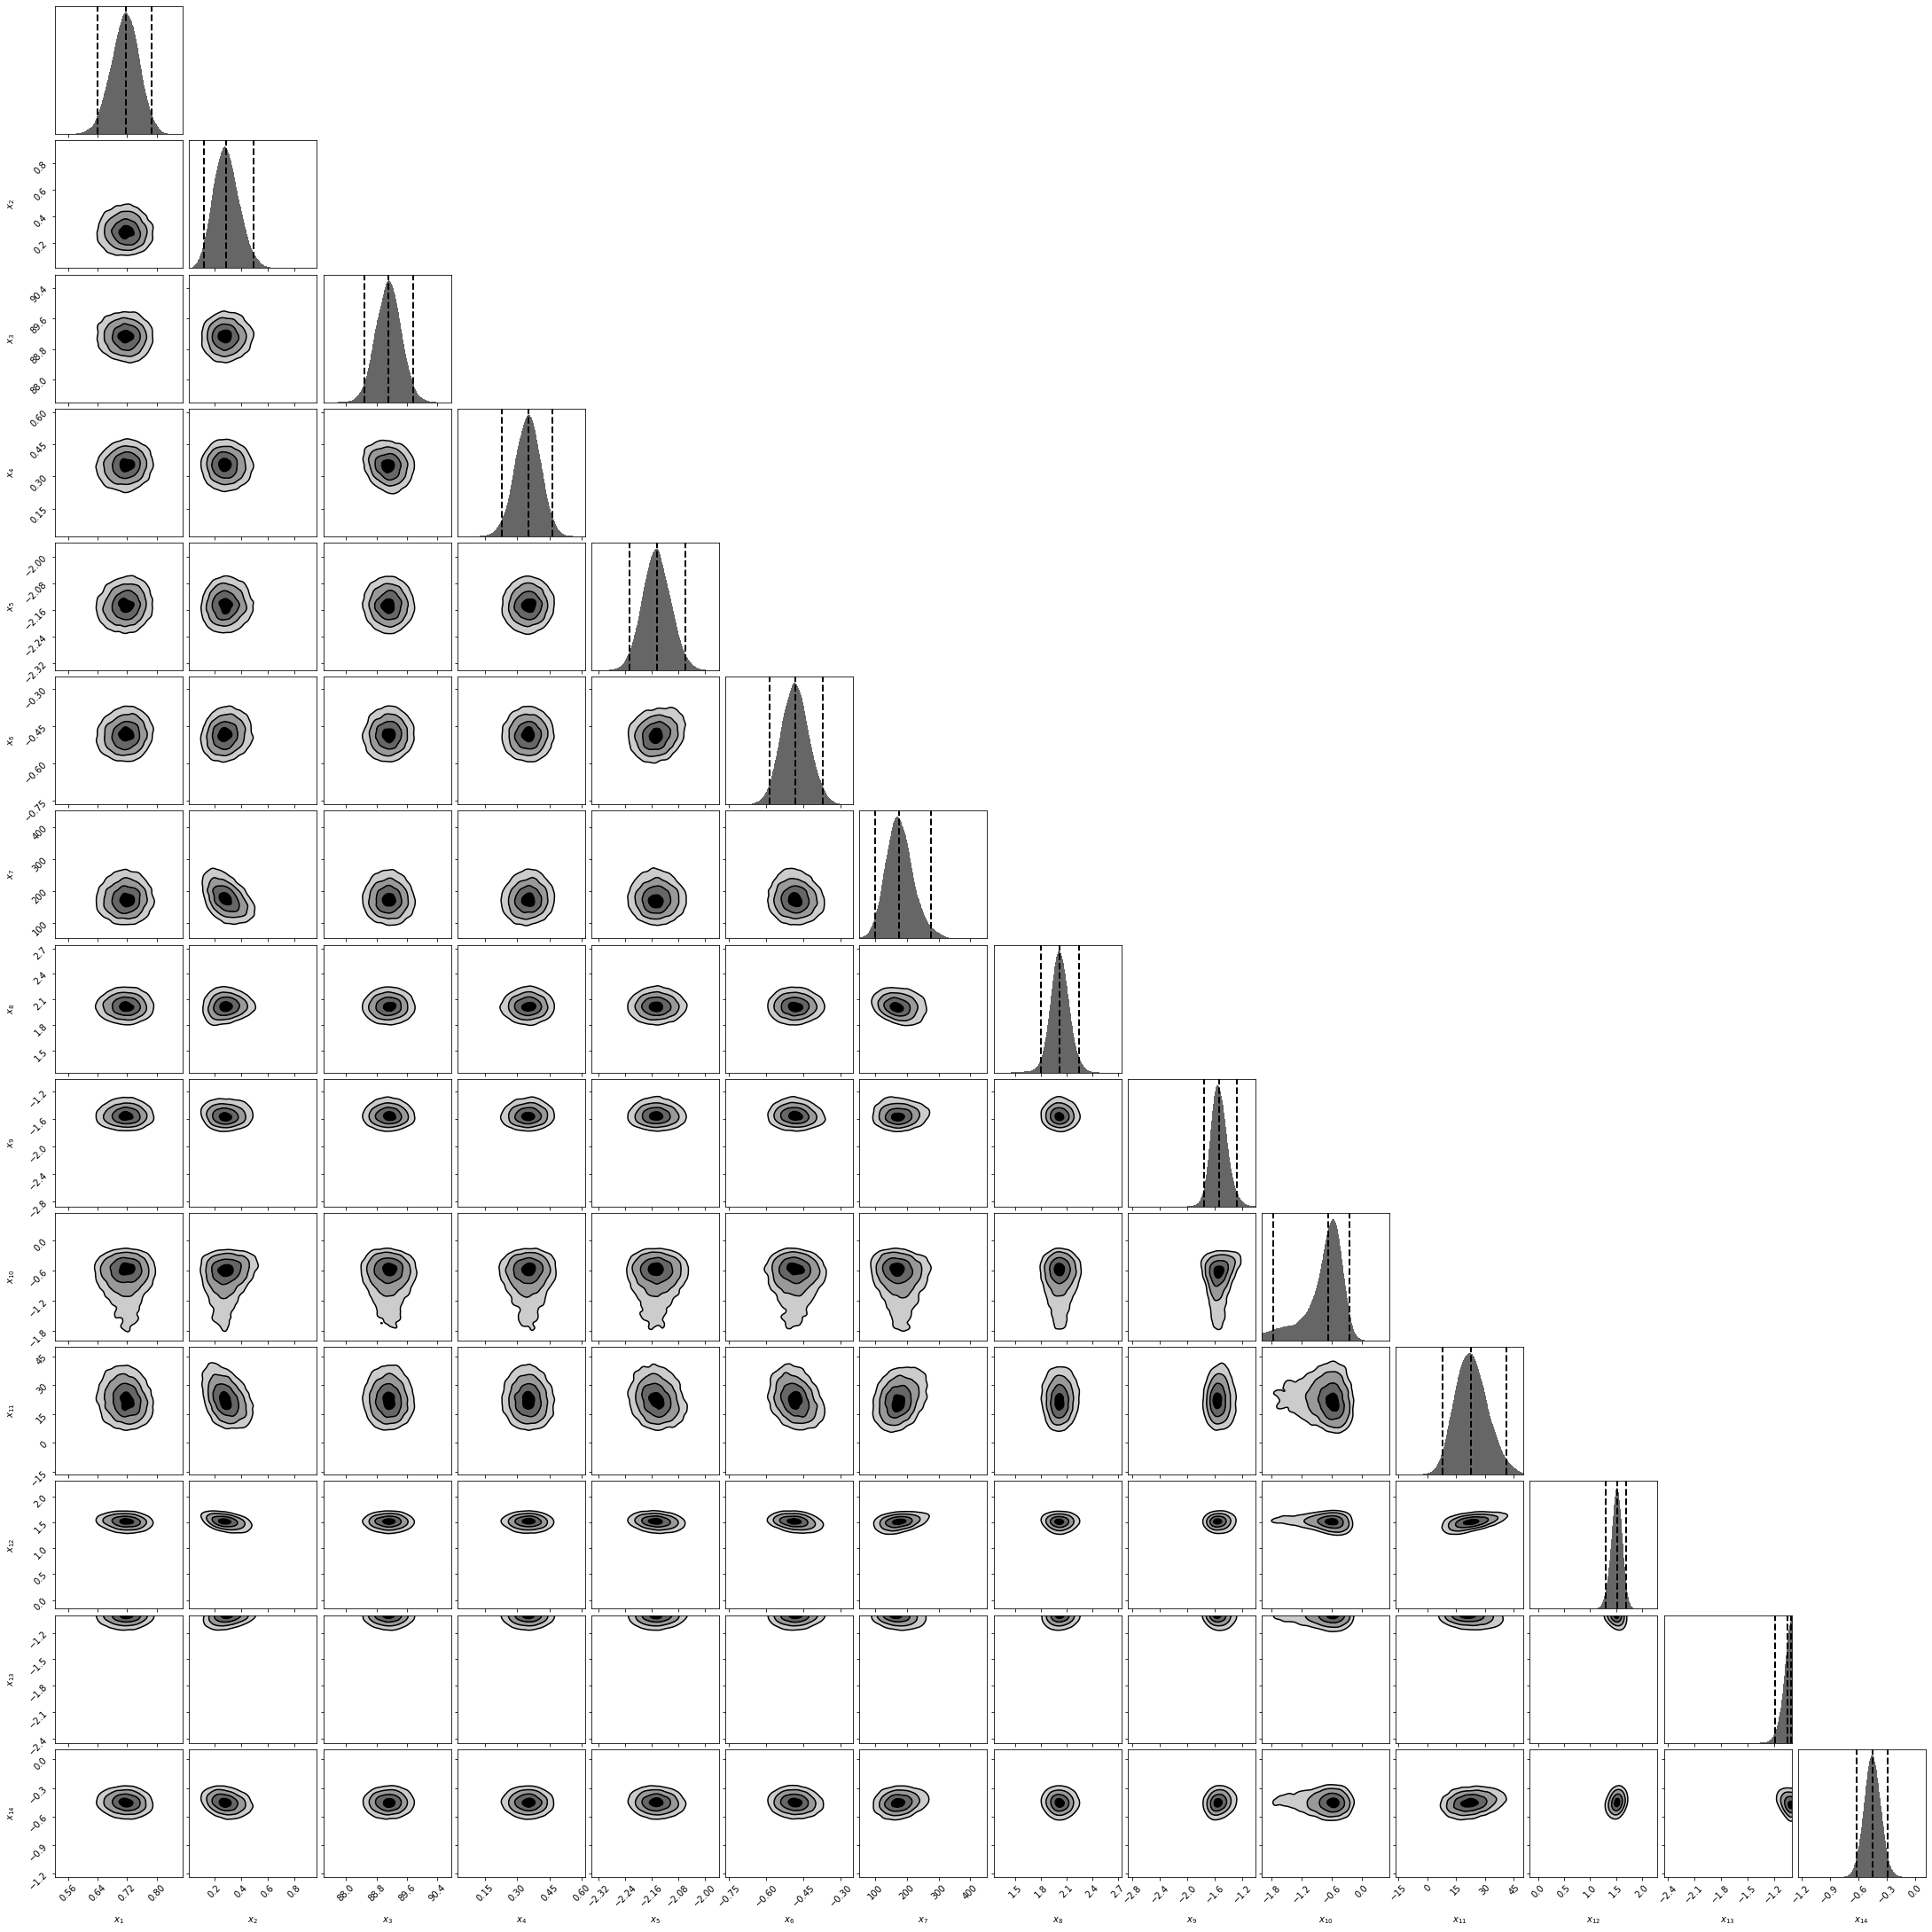

In [23]:
dyplot.cornerplot(dresults);

# KEY POINT: Resample the chain

dynesty has a function `dyplot.resample_equal`

Of course it's best to use the original samples with weights as that is a more accurate description of your posterior, but unless you're really in the tails of the distribution it shouldn't matter too much.

In [24]:
def resample_unweighted(dsampler):
    """ Takes a DynestyNestedSampler and returns unweighted samples """
    try:
        results = dsampler.results
    except:
        results = dsampler
    # I just snagged this bit of code from the cornerplot function
    try:
        weights = np.exp(results['logwt'] - results['logz'][-1])
    except:
        weights = results['weights']
    return dyplot.resample_equal(results["samples"], weights)


In [25]:
chain = resample_unweighted(dresults)

In [27]:
chain.shape

(30032, 14)

# More plots
After resampling to equally weighted samples, you can treat the chain the way you would with emcee output (the rest of this code is identical to before).

You can see the output of the fit as a corner plot. Basically you want everything to be nice and round, and if not that means you didn't initialize your walkers well enough or burn in for long enough.

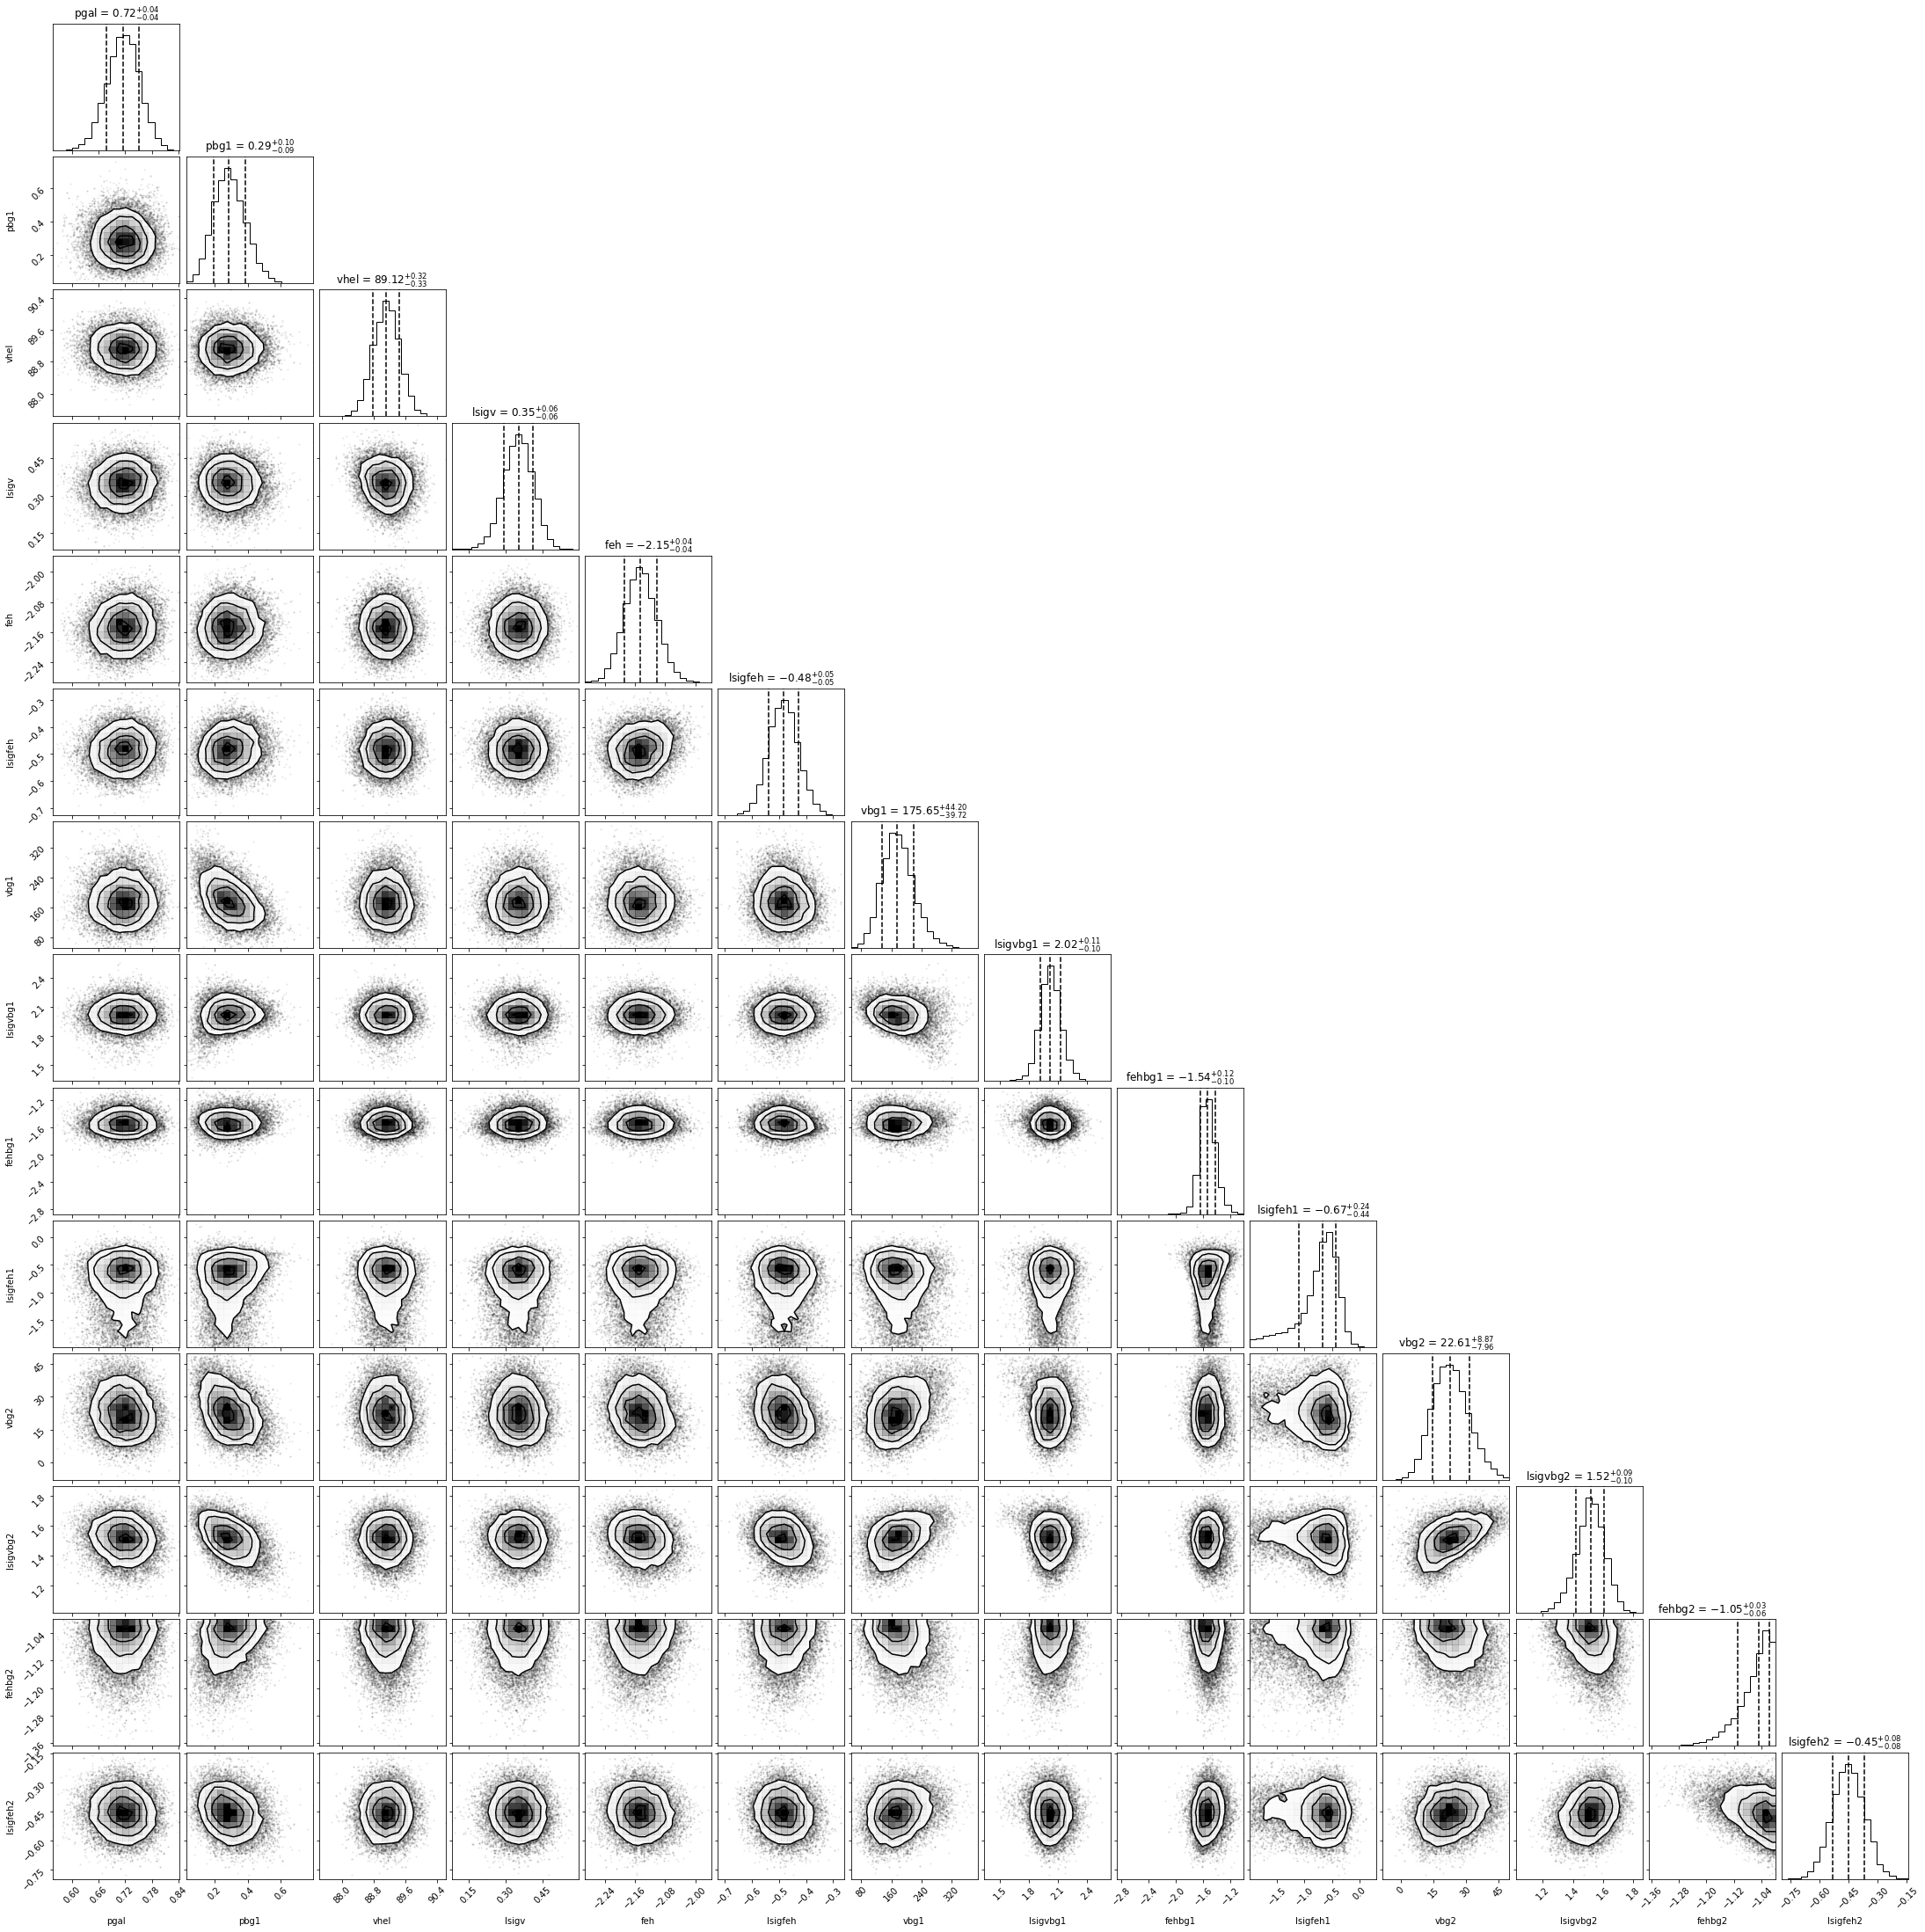

In [28]:
fig = corner.corner(chain, labels=param_labels, quantiles=[0.16,0.50,0.84], show_titles=True)

It's customary to summarize the data with percentiles, but you should check the corner plot diagonal to see if this is a good idea.

In [29]:
def process_chain(chain, avg_error=True):
    pctl = np.percentile(chain, [16, 50, 84], axis=0)
    meds = pctl[1]
    ep = pctl[2]-pctl[1]
    em = pctl[0]-pctl[1]
    if avg_error: # just for simplicity, assuming no asymmetry
        err = (ep-em)/2
        return OrderedDict(zip(param_labels, meds)), OrderedDict(zip(param_labels, err))
    else:
        return OrderedDict(zip(param_labels, meds)), OrderedDict(zip(param_labels, ep)), OrderedDict(zip(param_labels, em))

In [30]:
meds, errs = process_chain(chain)

In [31]:
for k,v in meds.items():
    print("{} {:.3f} {:.3f}".format(k, v, errs[k]))

pgal 0.716 0.038
pbg1 0.288 0.095
vhel 89.122 0.329
lsigv 0.351 0.059
feh -2.146 0.042
lsigfeh -0.485 0.054
vbg1 175.651 41.959
lsigvbg1 2.020 0.104
fehbg1 -1.542 0.112
lsigfeh1 -0.667 0.335
vbg2 22.612 8.416
lsigvbg2 1.518 0.094
fehbg2 -1.049 0.047
lsigfeh2 -0.452 0.083


Yay you are done! And now you can see the unusually low velocity dispersion of this galaxy:

In [32]:
10**meds["lsigv"]

2.245205587339843

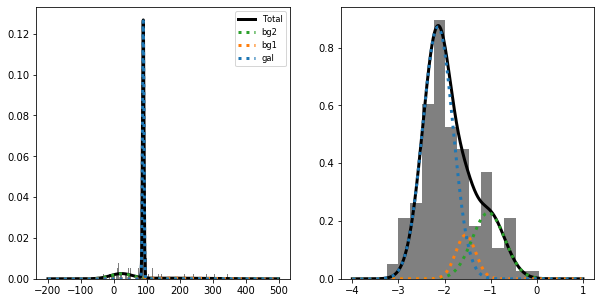

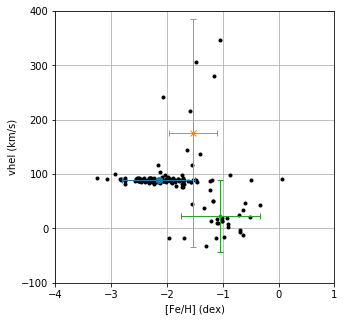

In [33]:
thetamed = list(meds.values())
fig1 = plot_1d_distrs(thetamed)
fig2 = plot_2d_distr(thetamed)